In [1]:
import xarray
import matplotlib.pyplot as plt

In [2]:
indexXr=xarray.merge([
    xarray.open_dataset('results/cmip6EcIndex.nc').sel(year=slice(1850,2098),experiment='ssp585',drop='True'),
    xarray.open_dataset('results/cmip6ssp585TradIndecesTos.nc').sel(year=slice(1850,2098))
])


In [3]:
obsXr=xarray.open_dataset('results/obsIndeces.nc')

In [4]:
from scipy.stats import pearsonr
import numpy as np

In [5]:
def rollingCorrellations(xr,firstIndex,otherIndex):
    
    years=np.arange(xr.year[0]+15,xr.year[-1]-14)
    
    
    rLs=list()
    pLs=list()
    qLs=list()
    for iYear in years:
        qLs.append(
                np.polyfit(
                    xr[firstIndex].sel(year=slice(iYear-15,iYear+14)),
                    xr[otherIndex].sel(year=slice(iYear-15,iYear+14)),
                    1
                )[0]
            )

        r,p=pearsonr(
            xr[firstIndex].sel(year=slice(iYear-15,iYear+14)),
            xr[otherIndex].sel(year=slice(iYear-15,iYear+14))
        )
        rLs.append(r)
        pLs.append(p)

    return xarray.DataArray([qLs,rLs,pLs],
                     dims=['data','year'],
                     coords={
                         'data':['q','r','p'],
                         'year':years,
                     }
                    ).to_dataset('data')


In [6]:
indexXr

<xarray.Dataset>
Dimensions:                 (year: 249, model: 37)
Coordinates:
  * year                    (year) int64 1850 1851 1852 1853 ... 2096 2097 2098
  * model                   (model) object 'ACCESS-CM2' ... 'UKESM1-0-LL'
Data variables: (12/21)
    eIndex                  (model, year) float64 ...
    cIndex                  (model, year) float64 ...
    backgroundSstNoDetrend  (model, year) float64 ...
    nino3                   (model, year) float64 ...
    samWinter               (model, year) float64 ...
    samSummer               (model, year) float64 ...
    ...                      ...
    dmiNoDetrend            (model, year) float64 ...
    dmiRollingDetrend       (model, year) float64 ...
    eastIORollingDetrend    (model, year) float64 ...
    nino34RollingDetrend    (model, year) float64 ...
    westIORollingDetrend    (model, year) float64 ...
    nino4RollingDetrend     (model, year) float64 ...

nino34Dmi


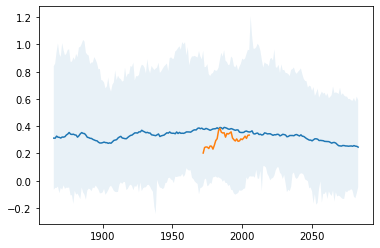

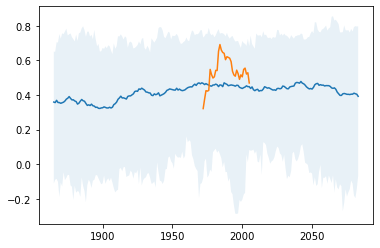

nino34Samsummer


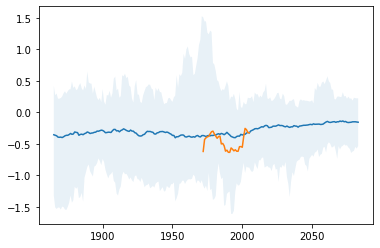

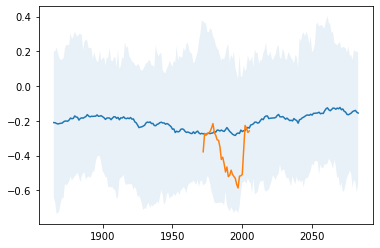

nino34Samwinter


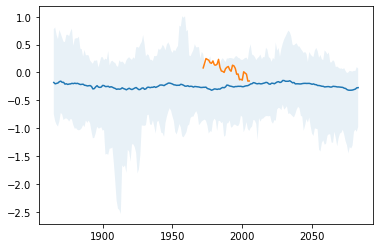

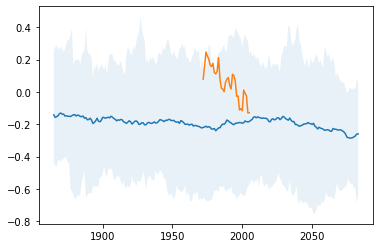

cIndexDmi


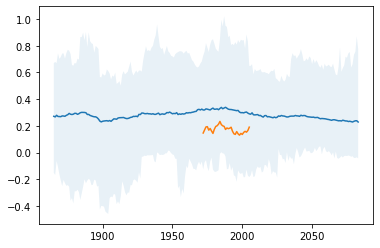

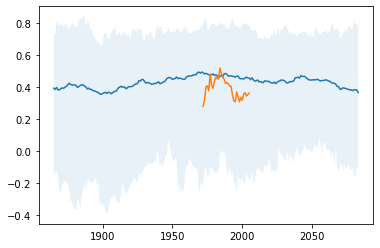

cIndexSamsummer


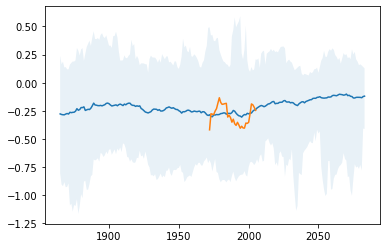

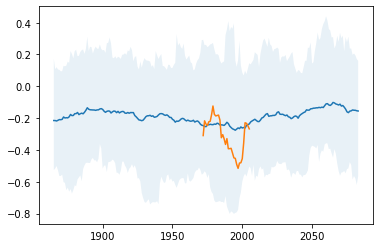

cIndexSamwinter


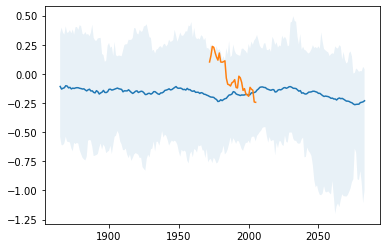

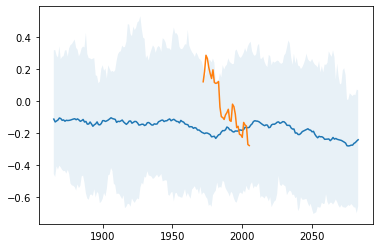

eIndexDmi


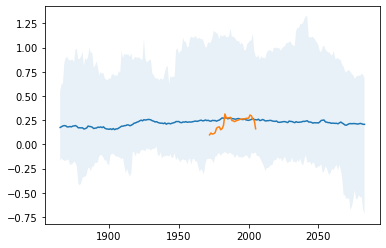

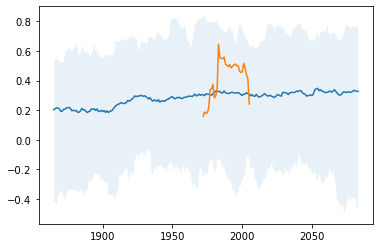

eIndexSamsummer


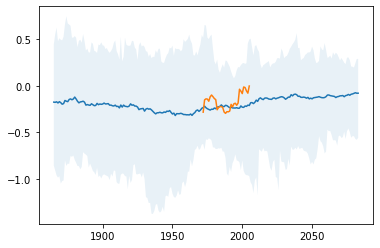

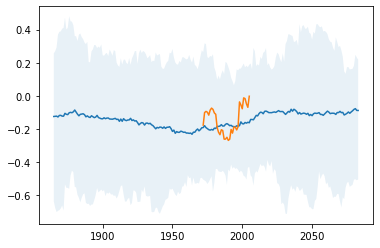

eIndexSamwinter


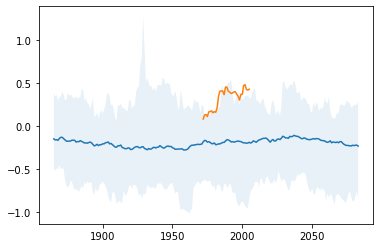

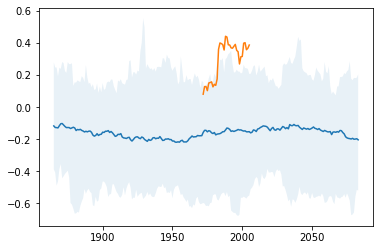

In [53]:
pairs=[
    ['nino34','dmi'],
    ['nino34','samSummer'],
    ['nino34','samWinter'],
    ['cIndex','dmi'],
    ['cIndex','samSummer'],
    ['cIndex','samWinter'],
    ['eIndex','dmi'],
    ['eIndex','samSummer'],
    ['eIndex','samWinter'],
]

for nino,other in pairs:

    print(nino+other.capitalize())

    modCorLs=list()
    for iMod in indexXr.model:

        modelXr=indexXr.sel(model=iMod,drop=True)



        modCorLs.append(
            rollingCorrellations(modelXr,nino,other)
        )


    correlationsXr=xarray.concat(modCorLs,'model')

    obsCorXr=rollingCorrellations(obsXr,nino,other)

    for plot in ['q','r']:
        plotData=correlationsXr[plot]

        #blue line for multi-experiment mean, and light blue shading between min and max
        plt.plot(
            plotData.year.values, 
            plotData.mean('model').values, 
            #label=indexToPlot[i], 
            #color=mainColor[i], 
        )
        plt.fill_between(
            plotData.year.values, 
            plotData.min('model').values, 
            plotData.max('model').values, 
        #    color=mainColor[i], 
            alpha=0.1
        )

        plt.plot(
            obsCorXr.year.values, 
            obsCorXr[plot].values, 
            #label=indexToPlot[i], 
            #color=mainColor[i], 
        )

        plt.show()

